<a href="https://colab.research.google.com/github/irisawa/opencv_freeze/blob/main/OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 5.9MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp36-none-any.whl size=4120275 sha256=148641854c37189e48874529b2311ba96ba9de26408aa77f37cbafc3154c491a
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfully built japanize-matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


インポート

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib 
import cv2

%matplotlib inline

ファイルの読み込み（自分のGoogleDriveに合わせて変更）

In [4]:
cap_file = cv2.VideoCapture('/content/gdrive/My Drive/movie/Bird_freeze.mp4')

読込できているかの確認(=True)

In [5]:
print(cap_file.isOpened())

True


ファイル情報の取得


In [6]:
fps = cap_file.get(cv2.CAP_PROP_FPS)
w = cap_file.get(cv2.CAP_PROP_FRAME_WIDTH)
h = cap_file.get(cv2.CAP_PROP_FRAME_HEIGHT)
frame_count = cap_file.get(cv2.CAP_PROP_FRAME_COUNT)
sec = frame_count / fps

print('fps : ', fps)
print('width : ', w)
print('height : ', h)
print('frame count : ', frame_count)
print('sec : ', round(sec, 3))

fps :  29.97002997002997
width :  1280.0
height :  720.0
frame count :  535.0
sec :  17.851


In [7]:
frames = []
while True:
    ret, frame = cap_file.read()
    if not ret:
        print("read end")
        break

    frames.append(frame)


if cap_file.isOpened():
    cap_file.release()

read end


In [8]:
len(frames)

535

In [9]:
frames[0].shape

(720, 1280, 3)

最初の５フレームを可視化<br>
OpenCVでのカラー画像はRGBではなく、BGRなので変換する必要がある<br>
ここはあまり本筋ではない。

Text(0.5, 0.98, 'BGRのまま')

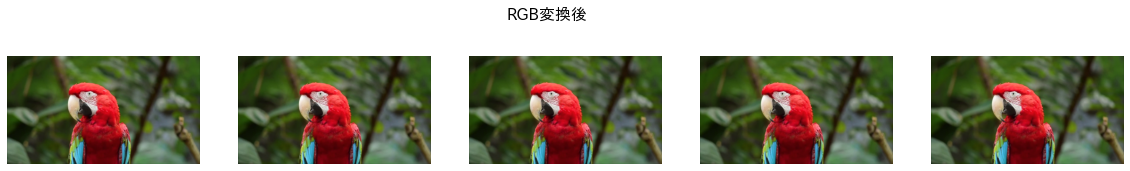

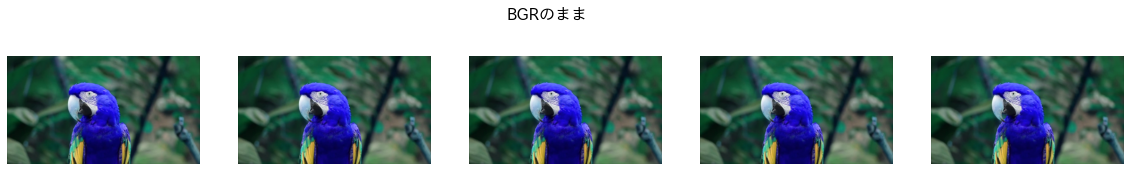

In [10]:
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
for frame, ax in zip(frames[:5], axes):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax.imshow(rgb_frame)
    ax.axis("off")
fig.suptitle("RGB変換後", fontsize=16)

fig, axes = plt.subplots(1, 5, figsize=(20, 3))
for frame, ax in zip(frames[:5], axes):
    ax.imshow(frame)
    ax.axis("off")
fig.suptitle("BGRのまま", fontsize=16)


フレーム配列内の後半にNoneが混入しているため、そこは除去

In [11]:
frames_gray = [x for x in frames if x is not None]

カラーでは差分を確認しにくいため、グレースケールに変換

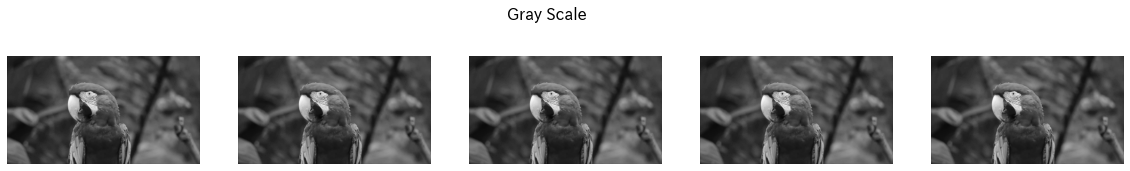

In [12]:
gray_frames = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in frames_gray]
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
for frame, ax in zip(gray_frames[:5], axes):
    ax.imshow(frame, cmap="gray", vmin=0, vmax=255)
    ax.axis("off")
_ = fig.suptitle("Gray Scale", fontsize=16)

フレーム間の差分（最初の５個だけ）を表示する。

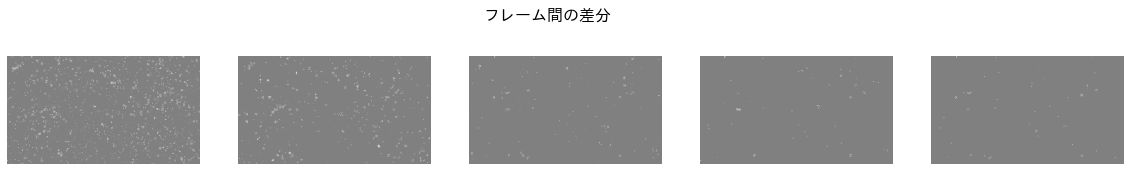

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
for bef, aft, ax in zip(gray_frames[:5], gray_frames[1:5+1], axes):
    diff_frame = aft - bef
    ax.imshow(diff_frame, cmap="gray", vmin=-255, vmax=255)
    ax.axis("off")

_ = fig.suptitle("フレーム間の差分", fontsize=16)

フレーム間の差分の確認<br>
２フレーム間で全く差がない場合のみその対象を表示

In [14]:
diff_frames_2 = [aft - bef for bef, aft in zip(gray_frames, gray_frames[1:])]
arr = []

for i, (bef, aft) in enumerate(zip(gray_frames, gray_frames[1:])):
    arr = aft - bef
    if (~arr.any(axis=0)).all():
        print(i)
        print(arr)

# 例えば5番目のフレーム差分をチェックした場合、
#print(arr[5])
#print(print(np.any(arr[5] > 0)))

動画全体のフレーム間でどれくらいの割合で異なっていたかを検査<br>
各フレーム差分を合計し、表示

In [15]:
diff_frames = [aft - bef for bef, aft in zip(gray_frames, gray_frames[1:])]
n_diff_pixels = (diff_frames[0] != 0).sum()
n_diff_pixels

42321

上記で出した差分を面積で割る

In [16]:
area = w * h
"{:.2%}".format(n_diff_pixels / area)

'4.59%'

ただ、これでは動画全体の変化率なので、下記に時系列で整理する。<br>

フレームごとに差分/面積で変化をグラフ化する。

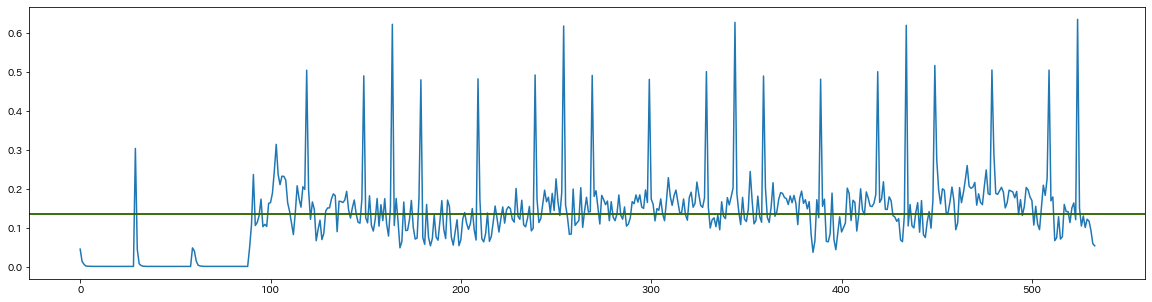

In [17]:
fig = plt.figure(figsize=(20, 5))

diff_rates = np.array([(d != 0).sum() / area for d in diff_frames])
mean = diff_rates.mean()
median = np.median(diff_rates)

plt.plot(diff_rates)
plt.axhline(mean, color="red")
_ = plt.axhline(median, color="green")

完全なフリーズフレームはないケースが多いため、閾値を定め検出するのが良い。<br>
わかりやすいように最初の１００個のフレーム間差分のみ表示。<br>

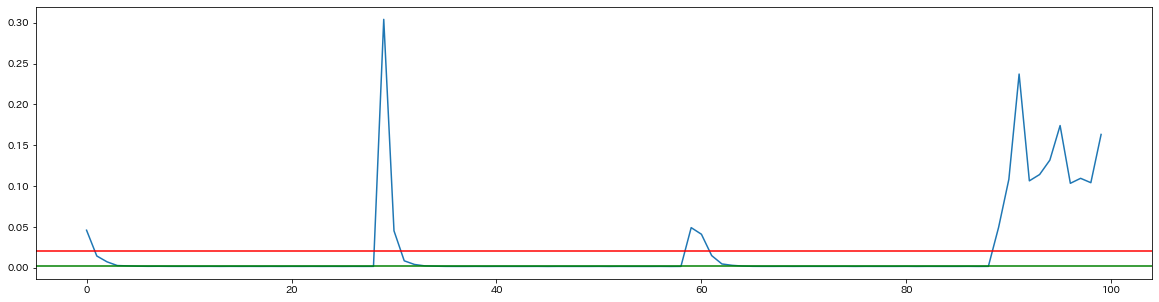

In [18]:
fig = plt.figure(figsize=(20, 5))

diff_rates = np.array([(d != 0).sum() / area for d in diff_frames[0:100]])
mean = diff_rates.mean()
median = np.median(diff_rates)

plt.plot(diff_rates)
plt.axhline(mean, color="red")
_ = plt.axhline(median, color="green")

要素数が多いためグラフ上では０に見えるが、実際は差分ゼロの箇所はない。

In [19]:
print(diff_frames[10])
print(diff_frames[10].mean())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0.2358713107638889
